In [ ]:
#----------------------------------------------
# Stefano Piacentini - 05/02/2020
#----------------------------------------------

library(rjags)

In [100]:
# Definition of saewtooth function
rate_sim = function(x, rx, 
                    A = 0.,
                    v = 1.,
                    phi = 0. * pi,
                    B = 0.,
                    SAW = 0) {
    
#    N_windows <- nrow(timewindows)
#    
#    timewindows_norm <- timewindows / 365
#    center <- (timewindows_norm[2] - timewindows_norm[1] )/ 2 + timewindows_norm[1]
    
#    ret <- 0
#    
#    for (i in 1:N_windows) {
#        if (x > timewindows_norm[i,1] && x < timewindows_norm[i,2]) {
#            x_0 <- center[i,1]
            ret <- A * cos(2 * pi * x / v + phi) + SAW * B * ( rx )
#            break
#        }
#    }
    return(ret)
} 

In [144]:
# Definition of the function return the right rescaled time
resc_t = function(x, timewindows) {
    
    N_windows <- nrow(timewindows)
    
    timewindows_norm <- timewindows / 365
    center <- (timewindows_norm[2] - timewindows_norm[1] )/ 2 + timewindows_norm[1]
    
    ret <- 0
    
    for (i in 1:N_windows) {
        if (x > timewindows_norm[i,1] && x < timewindows_norm[i,2]) {
#            print(x)
            x_0 <- center[i,1]
#            print(x_0)
            ret <- (x-x_0)
            break
        }
    }
    return(ret)
} 

In [145]:
# Loading time windows
timewindows <- read.table("timewindows.txt")

In [22]:
#rate_sim = function(x,
#                    A = 0.,
#                    v = 1.,
#                    phi = 0. * pi,
#                    B = 0.01,
#                    SAW = 0) {
#    ret <- A * cos(2 * pi * x / v + phi) -SAW * (B*v)/2. + SAW *B * ((x+0.15) %%v)
#    return(ret)
#}

In [146]:
dataframe <- read.table("dama_all.txt")

N_r <- nrow(dataframe)
t_real <- rep(1, N_r)
ren_t  <- rep(1, N_r)
x_real <- rep(1, N_r)
sd_real <- rep(1, N_r)

for (i in 1:N_r) {
    t_real[i] <- dataframe[i, 1]
    x_real[i] <- dataframe[i, 2]
    
    # dev std media a occhio dai plot
    if (t_real[i] <= 3000) {
        sd_real[i] <- 0.030/2
    } else if (t_real[i]< 5800 && t_real[i] > 3000) {
        sd_real[i] <- 0.015/2
    } else if (t_real[i]>= 5800) {
        sd_real[i] <- 0.009/2
    }
    
}
ren_t <- (t_real)/365

#rescaled time

time_resc <- rep(0, length(ren_t))
for(i in 1:length(time_resc)) {
    time_resc[i] <- resc_t(ren_t[i], timewindows)
}

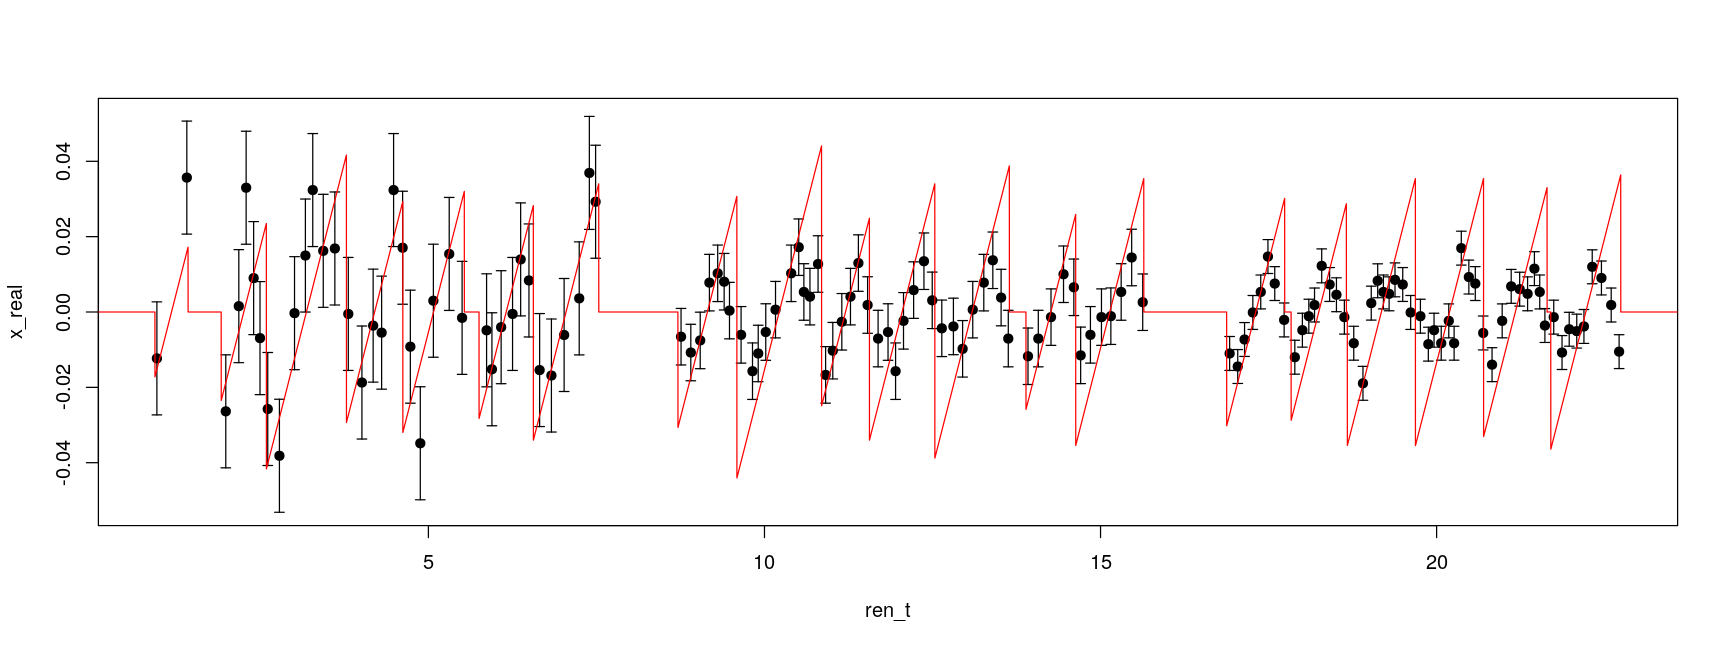

In [148]:
options(repr.plot.width=8*1.8, repr.plot.height=3*1.8)

plot(ren_t, x_real,
    pch=19, ylim = c(-1.5 * 0.035 , 1.5 * 0.035)
)
arrows(ren_t, x_real-sd_real, ren_t, x_real+sd_real, length=0.04, angle=90, code=3)

tmp <- seq(0., 25., by = 1e-3)
vec <- seq(0., 25., by = 1e-3)

for (i in 1:length(tmp)) {
    vec[i] <- resc_t(tmp[i], timewindows)  
}


vec <- rate_sim(x = tmp, rx= vec, SAW = 1,
                    A   = 0.,
                    phi = 0.0,
                    B   = 0.07,
                   )

lines(tmp, vec, col = 'red')

Warning message in jags.model(modello_cos, fitInput_r_cos, model_cos_init):
“Unused variable "ft" in data”
Warning message in jags.model(modello_cos, fitInput_r_cos, model_cos_init):
“Unused variable "width_B" in data”


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 139
   Unobserved stochastic nodes: 2
   Total graph size: 1128

Initializing model


Iterations = 11001:21000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

        Mean        SD  Naive SE Time-series SE
A   0.009781 0.0007618 7.618e-06      9.869e-06
phi 3.802539 0.0768989 7.690e-04      9.321e-04

2. Quantiles for each variable:

        2.5%      25%      50%     75%  97.5%
A   0.008285 0.009264 0.009772 0.01029 0.0113
phi 3.652678 3.749533 3.802127 3.85602 3.9490



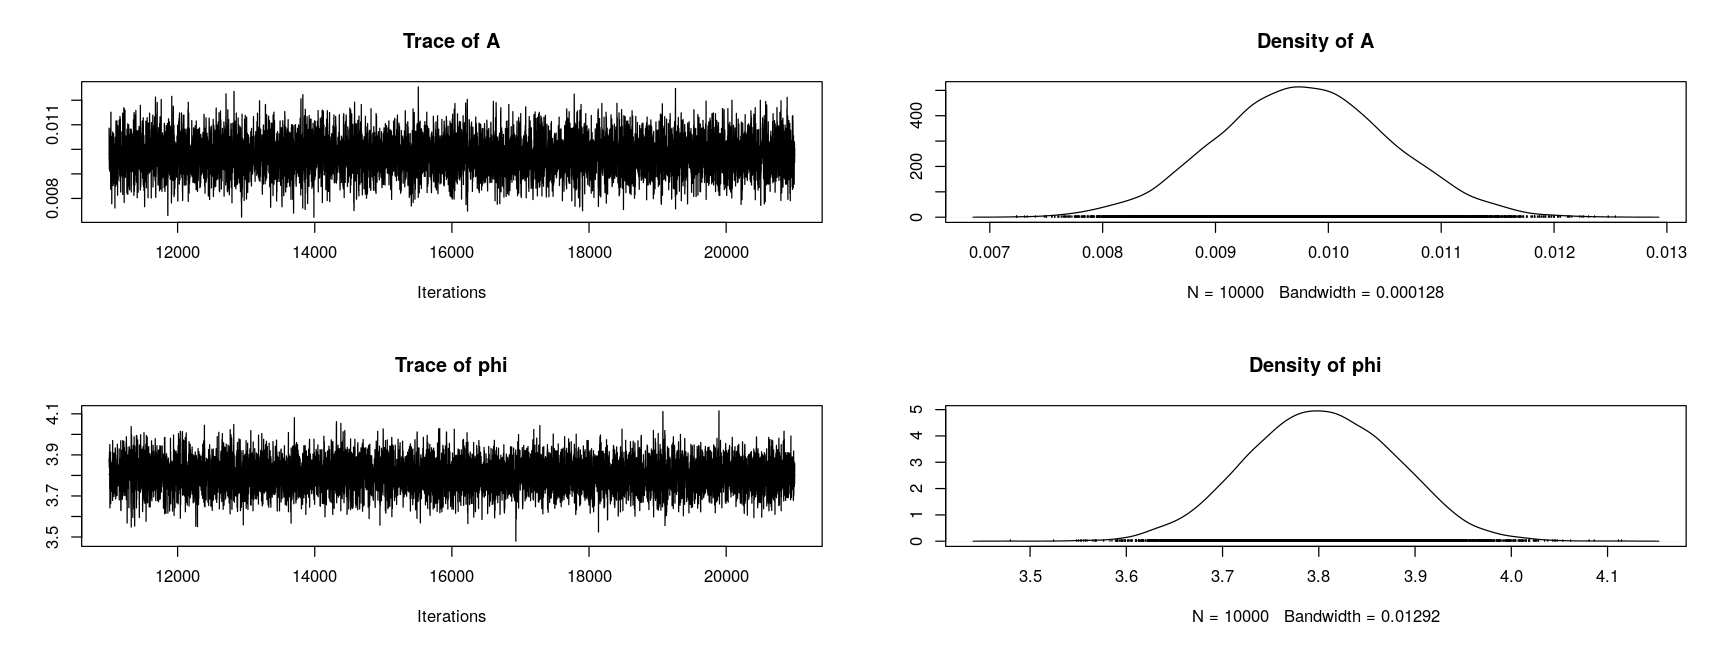

In [147]:
# FIT OF THE REAL DATA WITH COS


# Setting parameters for unif. priors
max_Acos     <- 0.05
max_Bcos     <- 0.03
max_phicos   <- 2 * pi


modello_cos    <-    "COS.bug" # file con modello di puro segnale

model_cos_init    <- list(A = 0.02, phi = pi /4.)

fitInput_r_cos <- NULL

fitInput_r_cos$n      <- N_r
fitInput_r_cos$x      <- x_real
fitInput_r_cos$sd     <- sd_real
fitInput_r_cos$t      <- ren_t
fitInput_r_cos$ft     <- floor(ren_t+0.15)
fitInput_r_cos$v      <- 1
fitInput_r_cos$pi     <- pi
    
# prior parameters
fitInput_r_cos$max_A   <- max_Acos
fitInput_r_cos$max_phi <- max_phicos
fitInput_r_cos$width_B   <- max_Bcos

    
m_cos_r <- jags.model(modello_cos,
                    fitInput_r_cos,
                    model_cos_init
                   )

update(m_cos_r, 10000)                  # burn in 

to.sample_cos_r = c('A', 'phi')

catena_cos_r <- coda.samples(m_cos_r, to.sample_cos_r, n.iter=10000)  # sampling 
    
mcmc_cos_r <- as.mcmc(catena_cos_r)

print(summary(catena_cos_r))

plot(catena_cos_r)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 139
   Unobserved stochastic nodes: 3
   Total graph size: 1927

Initializing model


Iterations = 11001:21000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

        Mean        SD  Naive SE Time-series SE
A   0.009308 0.0008937 8.937e-06      1.772e-05
B   0.003278 0.0032173 3.217e-05      8.774e-05
phi 3.650018 0.1238742 1.239e-03      3.330e-03

2. Quantiles for each variable:

         2.5%      25%      50%      75%    97.5%
A    0.007576 0.008709 0.009299 0.009889 0.011115
B   -0.002923 0.001092 0.003202 0.005398 0.009711
phi  3.423818 3.564484 3.643823 3.731005 3.905877



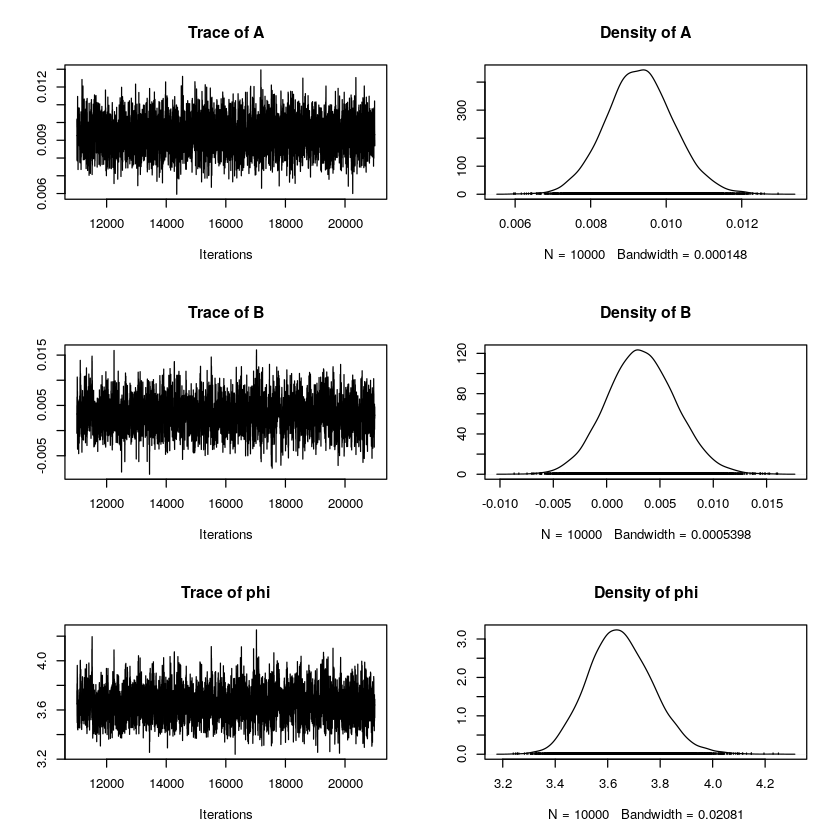

In [5]:
# FIT OF THE REAL DATA WITH SAWCOS


# Setting parameters for unif. priors
#B_0saw       <- 0.02
#max_Asaw     <- 0.00001
#width_Bsaw   <- 0.02
#max_phisaw   <- 0.0001
#max_Asaw     <- 0.05
#max_Bsaw   <- 0.03
#max_phisaw   <- 2 * pi

#modello_saw    <-    "SAWCOS.bug" # file con modello di puro segnale

#model_saw_init    <- list(A = 0.02, B = 0.01, phi = pi/4)
#model_saw_init    <- list(A = 0., B = 0.01, phi = 0.)

#fitInput_r_saw <- NULL

#fitInput_r_saw$n      <- N_r
#fitInput_r_saw$x      <- x_real
#fitInput_r_saw$sd     <- sd_real
#fitInput_r_saw$t      <- ren_t
#fitInput_r_saw$ft     <- floor(ren_t+0.15)
#fitInput_r_saw$v      <- 1
#fitInput_r_saw$pi     <- pi
    
# prior parameters
#fitInput_r_saw$max_A   <- max_Asaw
#fitInput_r_saw$max_phi <- max_phisaw
#fitInput_r_saw$max_B   <- max_Bsaw

    
#m_saw_r <- jags.model(modello_saw,
                    fitInput_r_saw,
                    model_saw_init
                   )

#update(m_saw_r, 10000)                  # burn in 

#to.sample_saw_r = c('A', 'B', 'phi')

#catena_saw_r <- coda.samples(m_saw_r, to.sample_saw_r, n.iter=10000)  # sampling 
    
#mcmc_saw_r <- as.mcmc(catena_saw_r)

#print(summary(catena_saw_r))

#plot(catena_saw_r)

Warning message in jags.model(modello_osaw, fitInput_r_osaw, model_osaw_init):
“Unused variable "t" in data”
Warning message in jags.model(modello_osaw, fitInput_r_osaw, model_osaw_init):
“Unused variable "v" in data”
Warning message in jags.model(modello_osaw, fitInput_r_osaw, model_osaw_init):
“Unused variable "pi" in data”
Warning message in jags.model(modello_osaw, fitInput_r_osaw, model_osaw_init):
“Unused variable "max_A" in data”
Warning message in jags.model(modello_osaw, fitInput_r_osaw, model_osaw_init):
“Unused variable "max_phi" in data”


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 139
   Unobserved stochastic nodes: 1
   Total graph size: 553

Initializing model


Iterations = 11001:21000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

          Mean             SD       Naive SE Time-series SE 
     1.827e-02      1.876e-03      1.876e-05      2.442e-05 

2. Quantiles for each variable:

   2.5%     25%     50%     75%   97.5% 
0.01461 0.01699 0.01827 0.01953 0.02197 



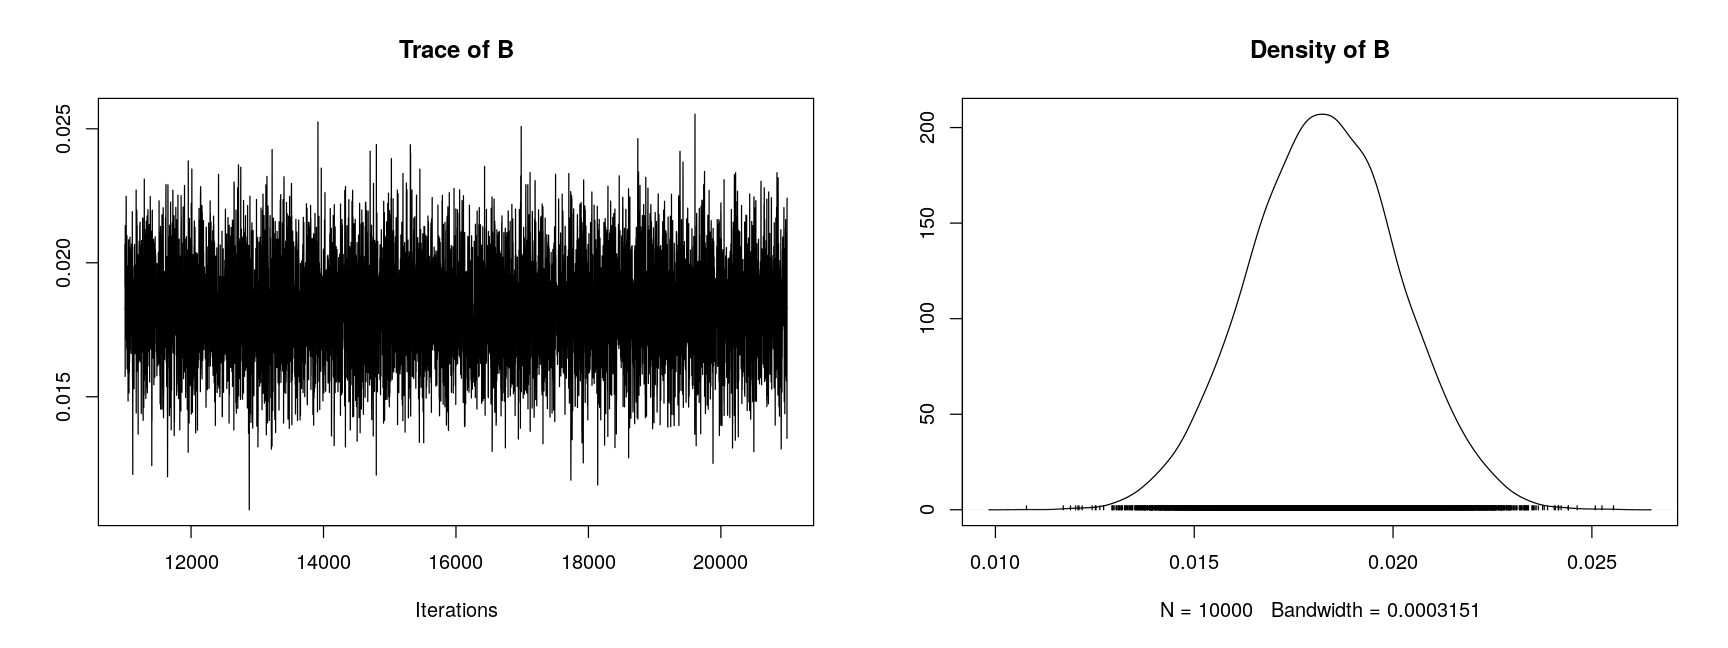

In [149]:
    # FIT OF THE REAL DATA WITH ONLYSAW


# Setting parameters for unif. priors
#B_0saw       <- 0.02
#max_Asaw     <- 0.00001
#width_Bsaw   <- 0.02
#max_phisaw   <- 0.0001
max_Aosaw     <- 0.05
max_Bosaw     <- 0.03
max_phiosaw   <- 2 * pi

modello_osaw    <-    "ONLYSAW.bug" # file con modello di puro segnale

#model_saw_init    <- list(A = 0.02, B = 0.01, phi = pi/4)
model_osaw_init    <- list(B = 0.01)


fitInput_r_osaw <- NULL

fitInput_r_osaw$n      <- N_r
fitInput_r_osaw$x      <- x_real
fitInput_r_osaw$sd     <- sd_real
fitInput_r_osaw$t      <- ren_t
fitInput_r_osaw$ft     <- time_resc
fitInput_r_osaw$v      <- 1
fitInput_r_osaw$pi     <- pi
    
# prior parameters
fitInput_r_osaw$max_A   <- max_Aosaw
fitInput_r_osaw$max_phi <- max_phiosaw
fitInput_r_osaw$max_B   <- max_Bosaw

    
m_osaw_r <- jags.model(modello_osaw,
                    fitInput_r_osaw,
                    model_osaw_init
                   )

update(m_osaw_r, 10000)                  # burn in 

to.sample_osaw_r = c('B')

catena_osaw_r <- coda.samples(m_osaw_r, to.sample_osaw_r, n.iter=10000)  # sampling 
    
mcmc_osaw_r <- as.mcmc(catena_osaw_r)

print(summary(catena_osaw_r))

plot(catena_osaw_r)

In [151]:
# First rough extimations of odds factors

    l_cos_r <- 1
    for (j in 1:N_r) {
        l_cos_r <- l_cos_r * dnorm(x_real[j],
                                         mean = rate_sim(ren_t[j],time_resc[j],
                                                         SAW = 0,
                                                         A   = mean(mcmc_cos_r[,"A"]),
                                                         phi = mean(mcmc_cos_r[,"phi"])
                                                         
                                                        ),
                                         sd = sd_real[j])
    }
#    l_saw_r <- 1
#    for (j in 1:N_r) {
#        l_saw_r <- l_saw_r * dnorm(x_real[j],
#                                         mean = rate_sim(ren_t[j],
#                                                         SAW = 1,
#                                                         A   = mean(mcmc_saw_r[,"A"]),
#                                                         phi = mean(mcmc_saw_r[,"phi"]),
#                                                         B   = mean(mcmc_saw_r[,"B"])),
#                                         sd = sd_real[j])
#    }

    l_osaw_r <- 1
    for (j in 1:N_r) {
        l_osaw_r <- l_osaw_r * dnorm(x_real[j],
                                         mean = rate_sim(ren_t[j], time_resc[j],
                                                         SAW = 1,
                                                         A   = 0,
                                                         phi = 0,
                                                         B   = mean(mcmc_osaw_r[,"B"])),
                                         sd = sd_real[j])
    }
    
   
    
    ock_cos_r <- sqrt(2*pi)^(2)*sd(mcmc_cos_r[,"A"])*
                                   sd(mcmc_cos_r[,"phi"])/(max_Acos * max_phicos);
    
#    ock_saw_r <- sqrt(2*pi)^(3)*sd(mcmc_saw_r[,"A"])*
#                                   sd(mcmc_saw_r[,"B"])*
#                                   sd(mcmc_saw_r[,"phi"])/(max_Asaw * (2*width_Bsaw) * max_phisaw);

    
    ock_osaw_r <- sqrt(2*pi)^(1)*sd(mcmc_osaw_r[,"B"])/(max_Bosaw);
    
    
#    O12_r <- (l_cos_r * ock_cos_r)/(l_saw_r*ock_saw_r);
#    O21_r <- 1/O12_r

    
    O13_r <- (l_cos_r * ock_cos_r)/(l_osaw_r*ock_osaw_r);
    O31_r <- 1/O13_r

    
#    O32_r <- (l_osaw_r * ock_osaw_r)/(l_saw_r*ock_saw_r);
#    O23_r <- 1/O32_r

In [153]:
# Odds ratios for data generated from cos modulations
O13_r
O31_r

[1] 7.983053e+14

[1] 1.252654e-15

In [8]:
ock_cos_r
ock_osaw_r

[1] 0.001159742

[1] 0.0002976048

In [9]:
log(l_cos_r)
log(l_osaw_r)
l_cos_r/l_osaw_r

[1] 490.1053

[1] 490.6112

[1] 0.6029378

In [155]:
# Computing the CHI2

#tmpx = rate_sim(ren_t, SAW = 0,
#                    A   = mean(mcmc_cos_r[,"A"]),
#                    phi = mean(mcmc_cos_r[,"phi"])
#                   )
#sum((x_real - tmpx)^2 / ((sd_real)^2))
#tmpx = rate_sim(ren_t, SAW = 1,
#                    A   = mean(mcmc_saw_r[,"A"]),
#                    B   = mean(mcmc_saw_r[,"B"]),
#                    phi = mean(mcmc_saw_r[,"phi"])
#                   )
#sum((x_real - tmpx)^2 / ((sd_real)^2))

chi2_cos =- 2 * ( log(l_cos_r) - sum(log(1/(sqrt(2*pi*sd_real^2)))))
print(chi2_cos)
#chi2_saw =- 2 * ( log(l_saw_r) - sum(log(1/(sqrt(2*pi*sd_real^2)))))
#print(chi2_saw)
chi2_osaw =- 2 * ( log(l_osaw_r) - sum(log(1/(sqrt(2*pi*sd_real^2)))))
print(chi2_osaw)

[1] 126.3715
[1] 204.7909


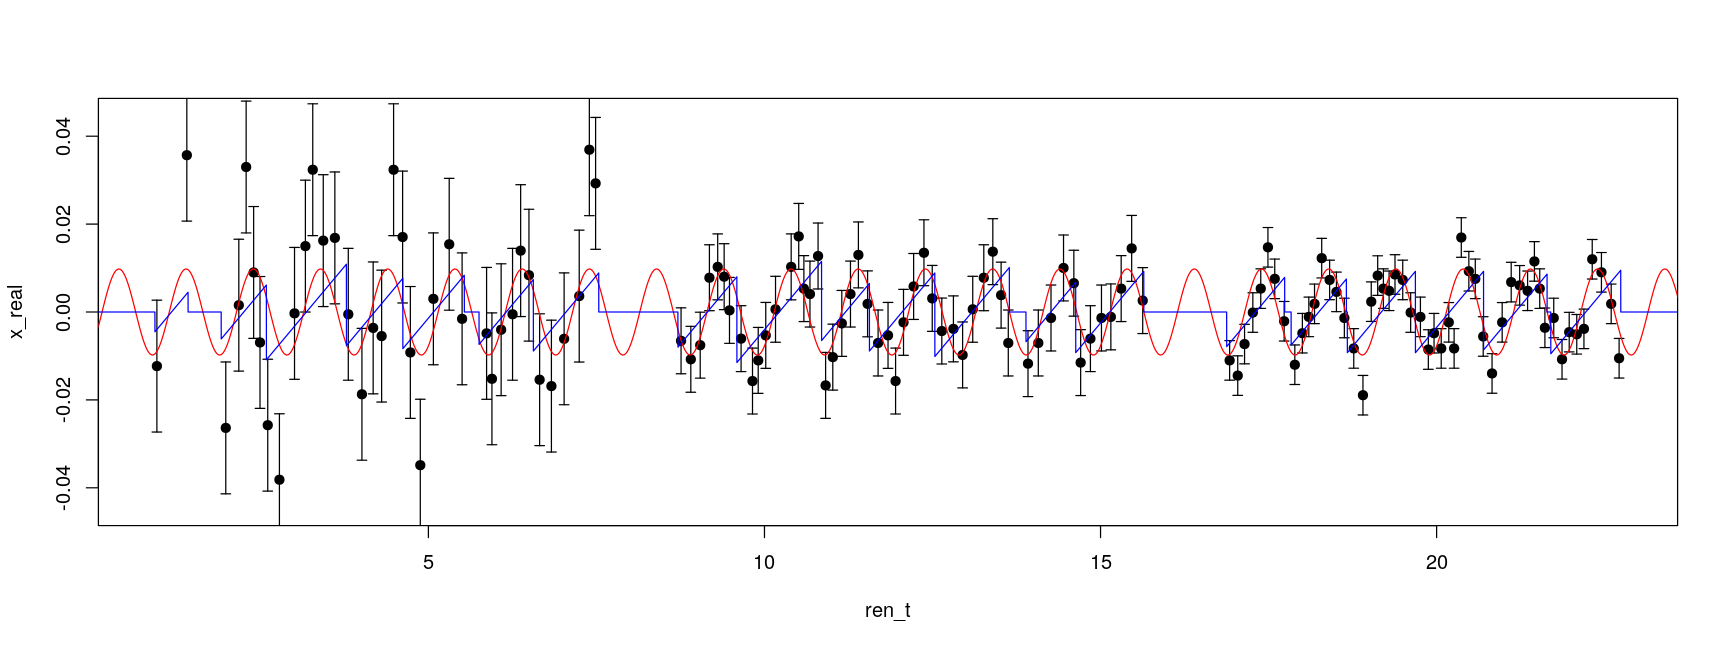

In [154]:
options(repr.plot.width=8*1.8, repr.plot.height=3*1.8)

plot(ren_t, x_real,
    pch=19, ylim = c(-1.5 * 0.03 , 1.5 * 0.03)
)
arrows(ren_t, x_real-sd_real, ren_t, x_real+sd_real, length=0.04, angle=90, code=3)

tmp <- seq(0., 25., by = 1e-3)
tr  <- seq(0., 25., by = 1e-3)

for (i in 1:length(tmp)) {
    tr[i] <- resc_t(tmp[i], timewindows)  
}

vec_cos <- rate_sim(x = tmp, rx= tr, SAW = 0,
                    A   = mean(mcmc_cos_r[,"A"]),
                    phi = mean(mcmc_cos_r[,"phi"])
                   )

vec_osaw <- rate_sim(x = tmp, rx= tr, SAW = 1,
                    A   = 0,
                    phi = 0,
                    B   = mean(mcmc_osaw_r[,"B"])
                   )

lines(tmp, vec_cos, col = 'red')
lines(tmp, vec_osaw,col= 'blue')


#lines(tmp, rate_sim(tmp, SAW = 0,
#                    A   = mean(mcmc_cos_r[,"A"]),
#                    phi = mean(mcmc_cos_r[,"phi"])
#                   ), col = 'red')
#lines(tmp, rate_sim(tmp, SAW = 1,
#                    A   = mean(mcmc_saw_r[,"A"]),
#                    phi = mean(mcmc_saw_r[,"phi"]),
#                    B   = mean(mcmc_saw_r[,"B"])
#                   ), col = 'blue')
#lines(tmp, rate_sim(tmp, SAW = 1,
#                    A   = 0,
#                    phi = 0,
#                    B   = mean(mcmc_osaw_r[,"B"])
#                   ), col = 'green')
#tmp2 <- 0*tmp
#lines(tmp, tmp2, col= 'green')

In [ ]:
library(bridgesampling)
library(R2jags)
library(mcmcplots)

In [36]:
### functions for evaluating the unnormalized posteriors on log scale ###


log_posterior_cos <- function(pars, data) {
      
      
  A   <- pars["A"]
  phi <- pars["phi"]

    
  sig <- A * cos(2. * pi * data$t / data$v + phi )


  out <-
      dunif(A, 0.0, data$max_A, log = TRUE) +          # prior
      dunif(phi, 0.0, data$max_phi, log = TRUE) +      # prior
      sum(dnorm(data$x, sig, data$sd, log = TRUE))       # likelihood

 return(out)  
}



In [37]:
### functions for evaluating the unnormalized posteriors on log scale ###


log_posterior_saw <- function(pars, data) {
      
      
  A   <- pars["A"]
  B   <- pars["B"]
  phi <- pars["phi"]

    
  sig <- A * cos(2. * pi * data$t / data$v + phi )
  bkg <- -(B*data$v)/2. + B * ((data$t+0.15) %% data$v)

    out <-
      dunif(A, 0.0, data$max_A, log = TRUE) +          # prior
      dunif(B, data$B_0 - data$width_B, data$B_0 + data$width_B, log = TRUE) +          # prior
      dunif(phi, 0.0, data$max_phi, log = TRUE) +      # prior
      sum(dnorm(data$x, sig+bkg, data$sd, log = TRUE))       # likelihood

 return(out)  
}

In [48]:
### functions for evaluating the unnormalized posteriors on log scale ###


log_posterior_osaw <- function(pars, data) {
      
      
  B   <- pars["B"]

    
  bkg <- -(B*data$v)/2. + B * ((data$t+0.15) %% data$v)

    out <-
      dunif(B, data$B_0 - data$width_B, data$B_0 + data$width_B, log = TRUE) +          # prior
      sum(dnorm(data$x, bkg, data$sd, log = TRUE))       # likelihood

 return(out)  
}

In [42]:
# specify parameter bounds for cos
cn <- c("A", "phi")
lb_cos <- rep(0, length(cn))
ub_cos <- rep(0, length(cn))
names(lb_cos) <- names(ub_cos) <- cn
lb_cos["phi"] = 0.0
ub_cos["phi"] = fitInput_r_cos$max_phi
lb_cos["A"] = 0.0 
ub_cos["A"] = fitInput_r_cos$max_A


In [43]:
# specify parameter bounds for cos
cn <- c("A", "B", "phi")
lb_saw <- rep(0, length(cn))
ub_saw <- rep(0, length(cn))
names(lb_saw) <- names(ub_saw) <- cn
lb_saw["phi"] = 0.0
ub_saw["phi"] = fitInput_r_saw$max_phi
lb_saw["A"] = 0.0 
ub_saw["A"] = fitInput_r_saw$max_A
lb_saw["B"] = fitInput_r_saw$B_0 - fitInput_r_saw$width_B 
ub_saw["B"] = fitInput_r_saw$B_0 + fitInput_r_saw$width_B 


In [44]:
# specify parameter bounds for cos
cn <- c("B")
lb_osaw <- rep(0, length(cn))
ub_osaw <- rep(0, length(cn))
names(lb_osaw) <- names(ub_osaw) <- cn
lb_osaw["B"] = fitInput_r_osaw$B_0 - fitInput_r_osaw$width_B 
ub_osaw["B"] = fitInput_r_osaw$B_0 + fitInput_r_osaw$width_B 


In [49]:
# compute log marginal likelihood via bridge sampling for H0
cos.bridge <- bridge_sampler(samples = catena_cos_r, data = fitInput_r_cos,
                            log_posterior = log_posterior_cos, lb = lb_cos,
                            ub = ub_cos, silent = TRUE, verbose = TRUE, maxiter = 300)

[1] "summary(q12): (log_dens of proposal (i.e., with dmvnorm) for posterior samples)"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -7.971   3.130   3.810   3.515   4.243   4.558 
[1] "summary(q22): (log_dens of proposal (i.e., with dmvnorm) for generated samples)"
[[1]]
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -4.966   3.156   3.857   3.544   4.252   4.558 

[1] "summary(q11): (log_dens of posterior (i.e., with log_posterior) for posterior samples)"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  476.9   486.4   487.1   486.8   487.6   487.9 
[1] "summary(q21): (log_dens of posterior (i.e., with log_posterior) for generated samples)"
[[1]]
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  478.6   486.5   487.2   486.9   487.6   487.9 



In [50]:
# compute log marginal likelihood via bridge sampling for H0
saw.bridge <- bridge_sampler(samples = catena_saw_r, data = fitInput_r_saw,
                            log_posterior = log_posterior_saw, lb = lb_saw,
                            ub = ub_saw, silent = TRUE, verbose = TRUE, maxiter = 300)

[1] "summary(q12): (log_dens of proposal (i.e., with dmvnorm) for posterior samples)"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -9.385   3.305   4.305   3.931   4.915   5.575 
[1] "summary(q22): (log_dens of proposal (i.e., with dmvnorm) for generated samples)"
[[1]]
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -4.231   3.530   4.396   4.077   4.985   5.576 

[1] "summary(q11): (log_dens of posterior (i.e., with log_posterior) for posterior samples)"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  477.2   485.2   486.2   485.8   486.8   487.4 
[1] "summary(q21): (log_dens of posterior (i.e., with log_posterior) for generated samples)"
[[1]]
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  476.6   485.4   486.3   485.9   486.8   487.4 



In [51]:
# compute log marginal likelihood via bridge sampling for H0
osaw.bridge <- bridge_sampler(samples = catena_osaw_r, data = fitInput_r_osaw,
                            log_posterior = log_posterior_osaw, lb = lb_osaw,
                            ub = ub_osaw, silent = TRUE, verbose = TRUE, maxiter = 300)

[1] "summary(q12): (log_dens of proposal (i.e., with dmvnorm) for posterior samples)"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-5.2409  0.9976  1.4421  1.1658  1.6223  1.6788 
[1] "summary(q22): (log_dens of proposal (i.e., with dmvnorm) for generated samples)"
[[1]]
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -6.497   1.022   1.454   1.180   1.627   1.679 

[1] "summary(q11): (log_dens of posterior (i.e., with log_posterior) for posterior samples)"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  413.7   422.2   423.5   423.1   424.4   425.1 
[1] "summary(q21): (log_dens of posterior (i.e., with log_posterior) for generated samples)"
[[1]]
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  412.2   422.2   423.4   423.0   424.3   425.1 



In [52]:
print(saw.bridge)

Bridge sampling estimate of the log marginal likelihood: 481.8741
Estimate obtained in 4 iteration(s) via method "normal".


In [53]:
error_measures(saw.bridge)

$re2
[1] 1.340846e-06

$cv
[1] 0.001157949

$percentage
[1] "0%"

In [21]:
print(cos.bridge)

Bridge sampling estimate of the log marginal likelihood: 483.3206
Estimate obtained in 4 iteration(s) via method "normal".


In [22]:
error_measures(cos.bridge)

$re2
[1] 3.989615e-07

$cv
[1] 0.000631634

$percentage
[1] "0%"

In [54]:
print(osaw.bridge)

Bridge sampling estimate of the log marginal likelihood: 422.0321
Estimate obtained in 21 iteration(s) via method "normal".


In [55]:
error_measures(osaw.bridge)

$re2
[1] 0.0001024242

$cv
[1] 0.01012049

$percentage
[1] "1%"

In [58]:
BF12 <- bf(cos.bridge, saw.bridge)
print(BF12)

Estimated Bayes factor in favor of cos.bridge over saw.bridge: 4.25234


In [59]:
post <- post_prob(cos.bridge, saw.bridge)
print(post)

cos.bridge saw.bridge 
 0.8096086  0.1903914 


In [60]:
BF13 <- bf(cos.bridge, osaw.bridge)
print(BF13)

Estimated Bayes factor in favor of cos.bridge over osaw.bridge: 414642634529758174620155904.00000


In [61]:
post <- post_prob(cos.bridge, osaw.bridge)
print(post)

  cos.bridge  osaw.bridge 
1.000000e+00 2.411715e-27 


In [62]:
BF23 <- bf(saw.bridge, osaw.bridge)
print(BF23)

Estimated Bayes factor in favor of saw.bridge over osaw.bridge: 97509335098328166556499968.00000


In [63]:
post <- post_prob(saw.bridge, osaw.bridge)
print(post)

  saw.bridge  osaw.bridge 
1.000000e+00 1.025543e-26 
